In [1]:
import pathlib
import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import os
import time
import matplotlib
import glob
import shutil
%matplotlib inline

Using TensorFlow backend.


In [2]:
def preprocess(image):
    image = tf.cast(image, tf.float32)
    image = image/255
    image = tf.image.resize(image, (64, 64))
    image = image[None, ...]
    if image.shape[-1] != 3:
        image = tf.image.grayscale_to_rgb(image)
    return image

def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)

    return parts[-1]

def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = tf.image.decode_image(img)

    return img, label

In [5]:
original = pathlib.Path('./tiny-imagenet-200/train/')
new = pathlib.Path('./tiny-imagenet-200/b_train/')
shutil.copytree(str(original), str(new))

'tiny-imagenet-200/b_train'

In [7]:
data_dir = pathlib.Path('./tiny-imagenet-200/train/')
CLASSES = sorted([item.name for item in data_dir.glob('*')])
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/images/*.JPEG'), shuffle=False)
labeled_ds = list_ds.map(process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [8]:
for i, elem in enumerate(list_ds):
    if i > 0:
        break
    print (elem)

tf.Tensor(b'tiny-imagenet-200/train/n01443537/images/n01443537_0.JPEG', shape=(), dtype=string)


In [9]:
# dict that is keyed by image name and returns bounding box coordinates
bounding_boxes = {}

def insert_bb_to_dict(file_path, d=bounding_boxes):
    file = open(file_path, 'r')
    line = file.readline()
    while line:
        tokens = line.split()
        image = tokens[0]
        coords = tuple(tokens[1:])
        d[image] = coords
        line = file.readline()
    file.close()
    return file_path

In [10]:
text_files = glob.glob(str(data_dir/'*/*_boxes.txt'))

In [11]:
for text_file in text_files:
    insert_bb_to_dict(text_file)

In [12]:
len(bounding_boxes)

100000

In [13]:
IMG_HEIGHT, IMG_WIDTH = 64, 64

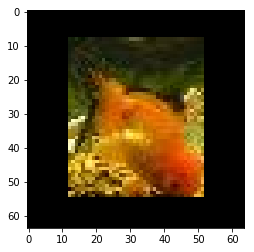

In [14]:
num_to_check = 2
for idx, (image, label) in enumerate(labeled_ds):
    if idx > num_to_check - 1:
        break
    image_name = label.numpy().decode('utf8')
    
    label = str(label.numpy())
    name = label.split('.')[0][2:]
    class_name = label.split('_')[0][2:]
#     print(label, name, class_name)
    
    coord = bounding_boxes[image_name]
    offset_height = int(coord[1]) # yminn
    offset_width = int(coord[0]) # xminn
    target_height = int(coord[3]) - offset_height
    target_width = int(coord[2]) - offset_width
#     print(offset_height, offset_width, target_height, target_width)
    cropped_image = tf.image.crop_to_bounding_box(image, offset_height, offset_width, target_height, target_width)
#     print(image_name)
    p_offset_height = (IMG_HEIGHT - target_height) // 2
    p_offset_width = (IMG_WIDTH - target_width) // 2
    padded_image = tf.image.pad_to_bounding_box(cropped_image, p_offset_height, p_offset_width, IMG_HEIGHT, IMG_WIDTH)
    plt.imshow(cropped_image)
    plt.imshow(padded_image)

In [20]:
bad_target, bad_saving = [], []

In [29]:
new_bad_save = []

In [30]:
start_time = time.time()
IMG_HEIGHT, IMG_WIDTH = 64, 64
counter = 1
for image, label in labeled_ds:
    image_name = label.numpy().decode('utf8')
    coord = bounding_boxes[image_name]

    label = str(label.numpy())
    name = label.split('.')[0][2:]
    if name not in bad_saving:
        continue
    class_name = label.split('_')[0][2:]

    offset_height = int(coord[1]) #yminn
    offset_width = int(coord[0]) #xminn
    target_height = int(coord[3]) - offset_height
    target_width = int(coord[2]) - offset_width
    if target_height <= 0 or target_width <= 0:
        bad_target.append(name)
        continue

    cropped_image = tf.image.crop_to_bounding_box(image, offset_height, offset_width, target_height, target_width)
    p_offset_height = (IMG_HEIGHT - target_height) // 2
    p_offset_width = (IMG_WIDTH - target_width) // 2
    padded_image = tf.image.pad_to_bounding_box(cropped_image, p_offset_height, p_offset_width, IMG_HEIGHT, IMG_WIDTH)
    try:
        matplotlib.image.imsave('./tiny-imagenet-200/b_train/{}/images/{}.JPEG'.format(class_name, name + 'bb'), padded_image)
    except:
        try:
            padded_image = preprocess(padded_image)[0]
            matplotlib.image.imsave('./tiny-imagenet-200/b_train/{}/images/{}.JPEG'.format(class_name, name + 'bb'), padded_image)
        except:
            print('saving changes didnt work')
            new_bad_save.append(name)

        
    if counter % 1000 == 0:
        print('\ntotal time so far:', time.time() - start_time)
        print('cropped images created:', counter)
    
    counter += 1
    
print('\ntotal time: ', time.time() - start_time)

(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)
(64, 3)


In [24]:
len(bad_target)

434

In [25]:
bad_target

['n01443537_425',
 'n01768244_309',
 'n01910747_16',
 'n01910747_229',
 'n01910747_347',
 'n01944390_173',
 'n01983481_490',
 'n02002724_196',
 'n02002724_273',
 'n02056570_233',
 'n02056570_387',
 'n02165456_164',
 'n02206856_102',
 'n02233338_150',
 'n02281406_329',
 'n02395406_101',
 'n02403003_260',
 'n02410509_288',
 'n02410509_31',
 'n02423022_101',
 'n02423022_434',
 'n02437312_157',
 'n02666196_146',
 'n02669723_364',
 'n02699494_125',
 'n02699494_141',
 'n02699494_165',
 'n02699494_188',
 'n02699494_248',
 'n02699494_270',
 'n02699494_345',
 'n02699494_414',
 'n02699494_466',
 'n02699494_472',
 'n02699494_67',
 'n02699494_88',
 'n02788148_496',
 'n02793495_84',
 'n02795169_269',
 'n02802426_1',
 'n02802426_109',
 'n02802426_114',
 'n02802426_120',
 'n02802426_123',
 'n02802426_156',
 'n02802426_164',
 'n02802426_175',
 'n02802426_179',
 'n02802426_193',
 'n02802426_21',
 'n02802426_224',
 'n02802426_232',
 'n02802426_233',
 'n02802426_253',
 'n02802426_262',
 'n02802426_275',


In [22]:
len(bad_saving)

1809

In [23]:
bad_saving

['n01644900_417',
 'n01644900_75',
 'n01698640_295',
 'n01698640_422',
 'n01698640_464',
 'n01698640_91',
 'n01742172_263',
 'n01768244_225',
 'n01768244_271',
 'n01768244_42',
 'n01768244_432',
 'n01768244_464',
 'n01768244_473',
 'n01768244_493',
 'n01768244_81',
 'n01770393_146',
 'n01770393_333',
 'n01770393_483',
 'n01774384_303',
 'n01774384_307',
 'n01774384_50',
 'n01774750_116',
 'n01774750_234',
 'n01774750_290',
 'n01774750_392',
 'n01774750_70',
 'n01855672_463',
 'n01855672_75',
 'n01882714_386',
 'n01910747_402',
 'n01917289_34',
 'n01944390_108',
 'n01944390_175',
 'n01944390_247',
 'n01944390_350',
 'n01944390_403',
 'n01945685_140',
 'n01945685_229',
 'n01945685_388',
 'n02002724_201',
 'n02058221_114',
 'n02058221_275',
 'n02074367_143',
 'n02074367_183',
 'n02085620_147',
 'n02085620_150',
 'n02085620_335',
 'n02094433_241',
 'n02094433_273',
 'n02094433_311',
 'n02099601_136',
 'n02099601_222',
 'n02099601_389',
 'n02099601_395',
 'n02099601_470',
 'n02099601_59',
 